In [1]:
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import random
import rl_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt

## Online SAC

In [2]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self,x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample()
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob

class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)
    
class SACContinuous:
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, 
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)

        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=critic_lr)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=critic_lr)

        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float).to(device)
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)

        self.target_entropy = target_entropy
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]
    
    def calc_target(self, rewards, next_state, dones):
        next_action, log_prob = self.actor(next_state)
        entropy = - log_prob
        q1_value = self.target_critic1(next_state, next_action)
        q2_value = self.target_critic2(next_state, next_action)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target
    
    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)
        rewards = (rewards + 8.0) / 8.0

        # Update critic
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(F.mse_loss(self.critic1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(F.mse_loss(self.critic2(states, actions), td_target.detach()))
        self.critic1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic1_optimizer.step()
        self.critic2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic2_optimizer.step()

        # Update actor 
        new_action, log_prob = self.actor(states)
        entropy = - log_prob
        q1_value = self.critic1(states, new_action)
        q2_value = self.critic2(states, new_action)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update alpha 
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic1, self.target_critic1)
        self.soft_update(self.critic2, self.target_critic2)


In [3]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-4
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = - env.action_space.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device)
return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)



Iteration 0:   0%|          | 0/10 [00:00<?, ?it/s]/var/folders/7f/k5b83t9j3638djfsdmtc1n_80000gn/T/ipykernel_83153/1419539145.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s, episode=100, return=-198.960]


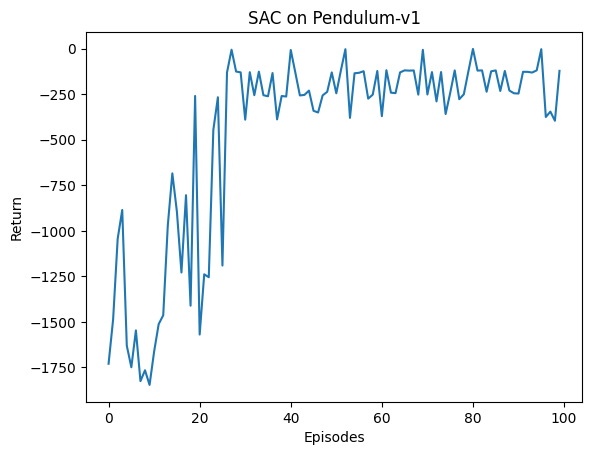

In [4]:
episodes_list  = list(range(len(return_list)))
plt.plot(episodes_list, return_list, label='SAC')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('SAC on {}'.format(env_name))
plt.show()

## Offline SAC

In [9]:
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-4
alpha_lr = 3e-4
hidden_dim = 256
gamma = 0.99
tau = 0.005
batch_size = 128
beta = 3.0
num_random = 10
num_epochs = 100
num_trains_per_epoch = 250

agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound, 
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device)
return_list = []
for i in range(10):
    with tqdm(total=int(num_epochs / 10), desc='Iteration %d' % i) as pbar:
        for i_epoch in range(int(num_epochs / 10)):
            epoch_return = 0
            state,_ = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                state = next_state
                epoch_return += reward
            return_list.append(epoch_return)

            for _ in range(num_trains_per_epoch):
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                transition_dict = {
                    'states': b_s,
                    'actions': b_a,
                    'next_states': b_ns,
                    'rewards': b_r,
                    'dones': b_d
                }
                agent.update(transition_dict)

            if (i_epoch + 1) % 10 == 0:
                pbar.set_postfix({
                    'epoch':
                    '%d' % (num_epochs / 10 * i + i_epoch + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it, epoch=100, return=-311.937]


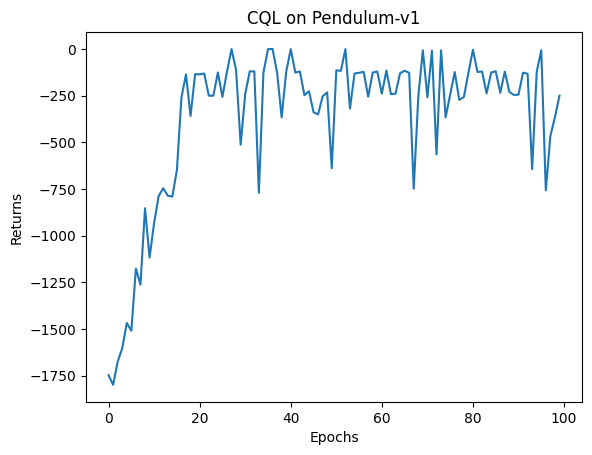

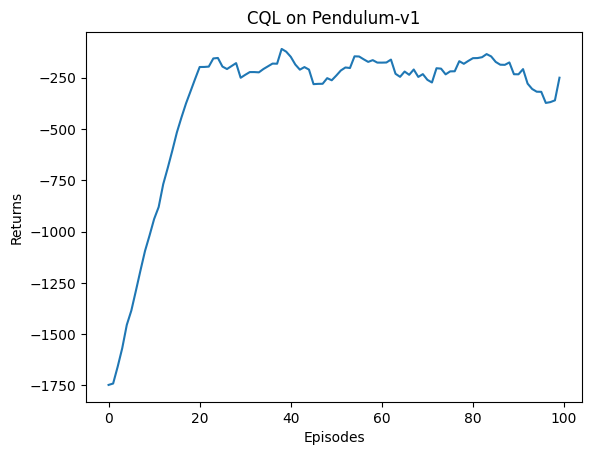

In [10]:
epochs_list = list(range(len(return_list)))
plt.plot(epochs_list, return_list)
plt.xlabel('Epochs')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()

## CQL-SAC

In [5]:
class CQL_SAC:
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, 
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device, beta, num_random):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=critic_lr)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=critic_lr)
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float).to(device)
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        self.target_entropy = target_entropy
        self.gamma = gamma
        self.tau = tau

        self.beta = beta
        self.num_random = num_random
        self.device = device

    def take_action(self,state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]
    
    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)
        rewards = (rewards + 8.0) / 8.0

        next_actions, log_prob = self.actor(next_states)
        entropy = - log_prob
        q1_value = self.critic1(next_states, next_actions)
        q2_value = self.critic2(next_states, next_actions)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        td_target = torch.clamp(td_target, min=-100, max=100)

        critic_1_loss = torch.mean(
            F.mse_loss(self.critic1(states, actions), td_target.detach()) 
        )
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic2(states, actions), td_target.detach()) 
        )

        # CQL update context (different from SAC)
        batch_size = states.shape[0]
        random_unif_actions = torch.rand(
            [batch_size * self.num_random, actions.shape[-1]], dtype=torch.float).uniform_(-1,1).to(self.device)
        random_unif_log_pi = torch.tensor(
                np.log(0.5 ** next_actions.shape[-1]),
                dtype=torch.float32,
                device=self.device
            )
        tmp_states = states.unsqueeze(1).repeat(1, self.num_random,1).view(-1, states.shape[-1])
        tmp_next_states = next_states.unsqueeze(1).repeat(1, self.num_random,1).view(-1, states.shape[-1])
        random_curr_actions, random_curr_log_pi = self.actor(tmp_states)
        random_next_actions, random_next_log_pi = self.actor(tmp_next_states)
        q1_unif = self.critic1(tmp_states, random_unif_actions).view(-1, self.num_random, 1)
        q2_unif = self.critic2(tmp_states, random_unif_actions).view(-1, self.num_random, 1)
        q1_curr = self.critic1(tmp_states, random_curr_actions).view(-1, self.num_random, 1)
        q2_curr = self.critic2(tmp_states, random_curr_actions).view(-1, self.num_random, 1)
        q1_next = self.critic1(tmp_states, random_next_actions).view(-1, self.num_random, 1)
        q2_next = self.critic2(tmp_states, random_next_actions).view(-1, self.num_random, 1)
        q1_cat = torch.cat([
            q1_unif - random_unif_log_pi,
            q1_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
            q1_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
        ], dim = 1)
        q2_cat = torch.cat([
            q2_unif - random_unif_log_pi,
            q2_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
            q2_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
        ], dim = 1)

        max_q1 = q1_cat.max(dim=1, keepdim=True).values
        qf1_loss_1 = (max_q1 + torch.log(torch.exp(q1_cat - max_q1).sum(dim=1, keepdim=True))).mean()
        max_q2 = q2_cat.max(dim=1, keepdim=True).values
        qf2_loss_1 = (max_q2 + torch.log(torch.exp(q2_cat - max_q2).sum(dim=1, keepdim=True))).mean()

        qf1_loss_2 = self.critic1(states, actions).mean()
        qf2_loss_2 = self.critic2(states, actions).mean()
        penalty1 = torch.clamp(qf1_loss_1 - qf1_loss_2, min=0, max=30)
        penalty2 = torch.clamp(qf2_loss_1 - qf2_loss_2, min=0, max=30)
        qf1_loss = critic_1_loss + self.beta * penalty1
        qf2_loss = critic_2_loss + self.beta * penalty2

        if torch.isnan(qf1_loss) or torch.isnan(qf2_loss):
            print("💥 NaN detected in critic loss!")
        if torch.isinf(qf1_loss) or torch.isinf(qf2_loss):
            print("💥 Inf detected in critic loss!")

        self.critic1_optimizer.zero_grad()
        qf1_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(self.critic1.parameters(), max_norm=50.0)
        self.critic1_optimizer.step()
        self.critic2_optimizer.zero_grad()
        qf2_loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(self.critic2.parameters(), max_norm=50.0)
        self.critic2_optimizer.step()

        # updat policy network
        new_actions, log_prob = self.actor(states)
        entropy = - log_prob
        q1_value = self.critic1(states, new_actions)
        q2_value = self.critic2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # update alpha
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic1, self.target_critic1)
        self.soft_update(self.critic2, self.target_critic2)


        


In [6]:
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-4
alpha_lr = 3e-4
hidden_dim = 256
gamma = 0.99
tau = 0.005
batch_size = 128
beta = 3.0
num_random = 10
num_epochs = 100
num_trains_per_epoch = 250

agent = CQL_SAC(state_dim, hidden_dim, action_dim, action_bound, 
                actor_lr, critic_lr, alpha_lr, target_entropy,tau, gamma, device, beta,
                num_random)
return_list = []
for i in range(10):
    with tqdm(total=int(num_epochs / 10), desc='Iteration %d' % i) as pbar:
        for i_epoch in range(int(num_epochs / 10)):
            epoch_return = 0
            state,_ = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                state = next_state
                epoch_return += reward
            return_list.append(epoch_return)

            for _ in range(num_trains_per_epoch):
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                transition_dict = {
                    'states': b_s,
                    'actions': b_a,
                    'next_states': b_ns,
                    'rewards': b_r,
                    'dones': b_d
                }
                agent.update(transition_dict)

            if (i_epoch + 1) % 10 == 0:
                pbar.set_postfix({
                    'epoch':
                    '%d' % (num_epochs / 10 * i + i_epoch + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 10/10 [00:45<00:00,  4.57s/it, epoch=100, return=-258.956]


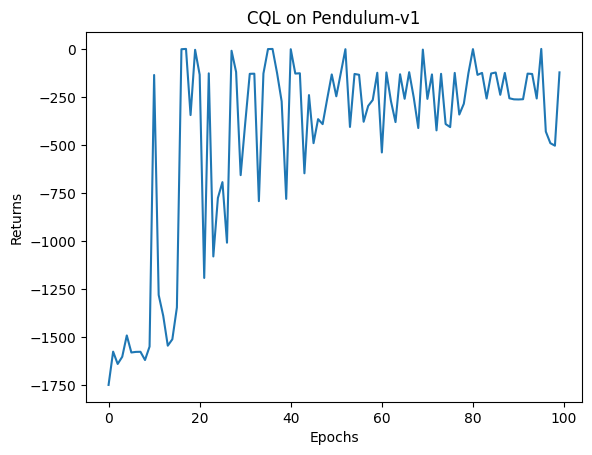

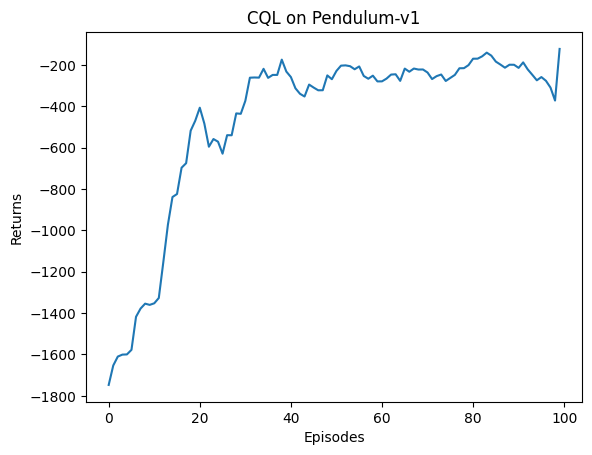

In [7]:
epochs_list = list(range(len(return_list)))
plt.plot(epochs_list, return_list)
plt.xlabel('Epochs')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()